# Scanpy: Preprocessing and clustering 3k PBMCs

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

（更新日:2021-4-28）

Scanpyを用いたクラスタリング解析の基本的なワークフローを紹介します。 Google ColabまたはJupyter notebook上で作業を行います。
内容はSeuratの[Guided tutorial](https://singlecellanalysistutorial.readthedocs.io/en/latest/notebooks/GuidedTutorial.html)とほぼ同じですので、そちらもあわせて参考にしてください。

## 前準備

Google Colabで本チュートリアルを実行する場合は まず下記コマンドでScanpyをインストールしてください。

In [ ]:
!pip install seaborn scikit-learn statsmodels numba python-igraph louvain leidenalg scanpy 

### データダウンロード（初回のみ）
Jupyterでは冒頭に ! 記号をつけるとLinuxコマンドを実行することができます。これをマジックコマンドと言います。

- **mkdir**はディレクトリを新規作成するLinuxコマンドです。
- **wget**を使って、今回の解析に用いるデータをWebからダウンロードし、ローカルに保存します。データサイズは7.27Mです。
- **tar**コマンドでダウンロードされた圧縮ファイルを解凍します。

In [ ]:
!mkdir -p data write
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2021-04-28 06:15:23--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-04-28 06:15:24--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.09s   

2021-04-28 06:15:24 (79.2 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [ ]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import scanpy as sc

# ログなどのパラメータ設定
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = 'write/pbmc3k.h5ad' # 出力ファイル名

入力データ（10X CellRangerで生成されたディレクトリ）を読み込み、[`AnnData`オブジェクト](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) に格納

In [ ]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # 入力ディレクトリ
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                             # 計算の高速化のためにキャッシュを利用する

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

adata

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

2700細胞 x 32738遺伝子のAnnDataが作成されました。

## Preprocessing
各細胞の全リードに対して占める割合が最も高い遺伝子を表示します。

normalizing counts per cell
    finished (0:00:00)


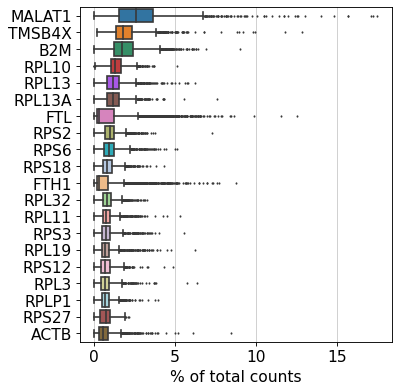

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### フィルタリング

発現遺伝子数が200未満の細胞、発現細胞数が3未満の遺伝子をフィルタします。

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


次にミトコンドリア遺伝子の発現量を計測します。
`pp.calculate_qc_metrics` 関数によって多数の品質評価指標を取得できます。

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

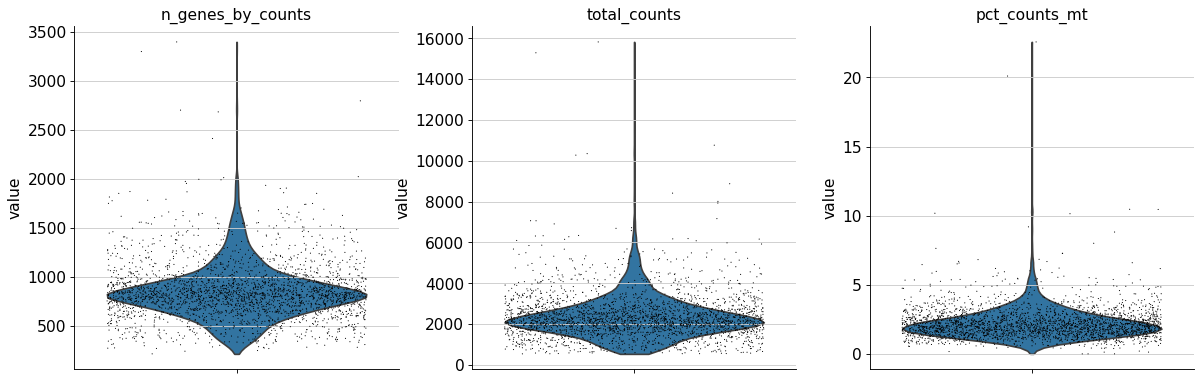

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

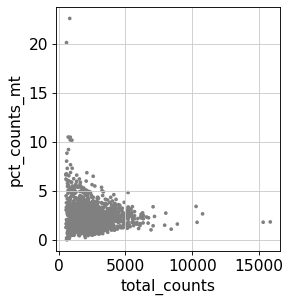

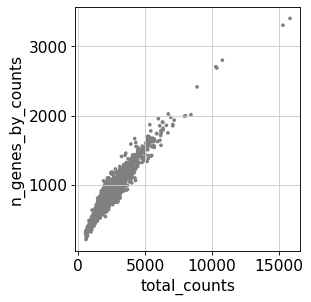

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

ミトコンドリア由来の遺伝子が多すぎる細胞、またはtotal countsの値が多すぎる細胞を削除します。

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


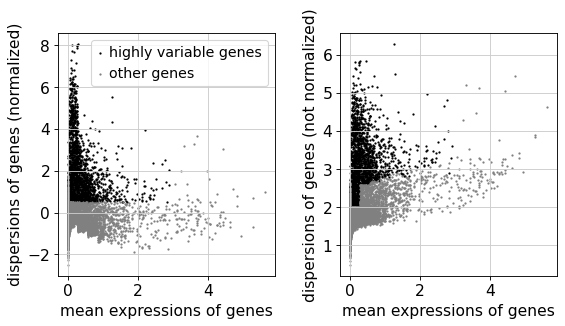

In [ ]:
# Total read countを10000に正規化
sc.pp.normalize_total(adata, target_sum=1e4)

# 対数変換
sc.pp.log1p(adata)

# highly-variable genesを検出
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 左が正規化後、右が正規化前の発現量(Y軸)
sc.pl.highly_variable_genes(adata)

正規化・対数化後の遺伝子発現データをrawdataとして AnnDataオブジェクトの`.raw` に格納します。

In [ ]:
adata.raw = adata

### highly-variable genes を抽出

注：ScanpyはPCAやその後に続く解析では自動的にhighly-variable genes のみを利用するため、このフィルタリングステップは必要ないことが多い

In [ ]:
# adata = adata[:, adata.var.highly_variable]

### スケーリング

細胞あたりのUMI数とミトコンドリア遺伝子の発現率の効果を再調整します。データを単位分散にスケールします。

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# 標準偏差10を超える値はクリップする
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:01:03)


## 主成分分析（PCA）

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


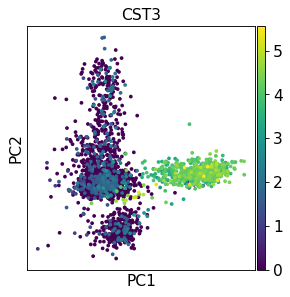

In [ ]:
sc.pl.pca(adata, color='CST3')

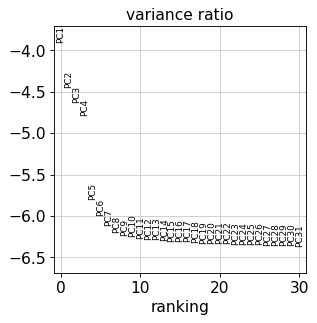

In [ ]:
# 主成分の寄与率を表示
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## 近傍グラフの計算

得られたPCAデータを用いて細胞の近傍グラフを計算します。ここではPC40まで使います。

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)


### Embedding the neighborhood graph

- UMAPを使って２次元まで次元削減します。これはtSNEよりも多様体のグローバルな接続性に忠実である可能性があります。
- いくつかのケースでは、クラスタが切断されていたり、似たような連結の切断が見られることがあります。

In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


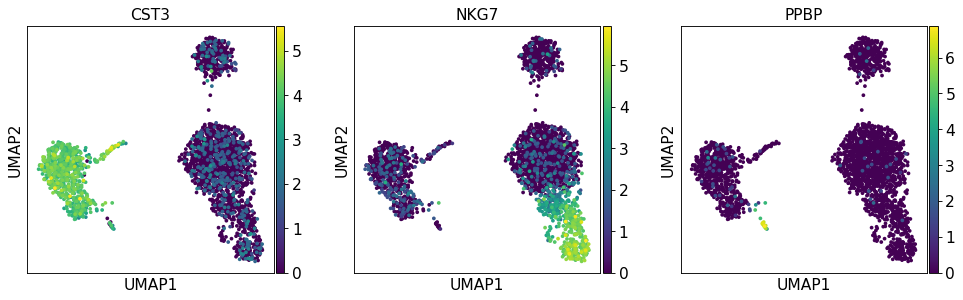

In [ ]:
# 正規化後の発現量でヒートマップ
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

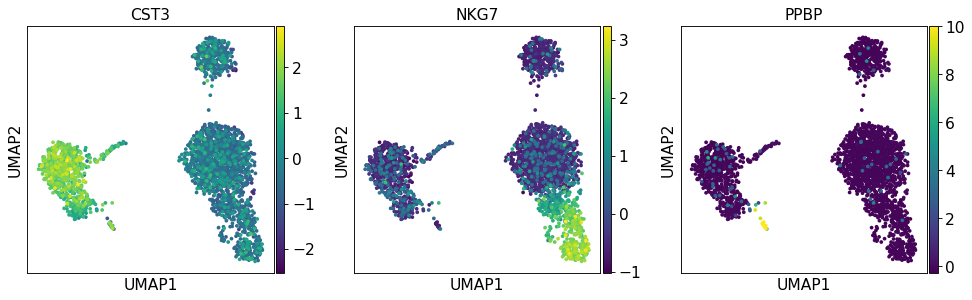

In [ ]:
# 正規化された発現量を更に分散でcorrectしたもの（Z値）
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering

他のツール群と同様に、Leiden graph-clustering methodを推奨します。
Leiden clusteringは先ほど計算した neighborhood graphを用いてクラスタリングします。

In [ ]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


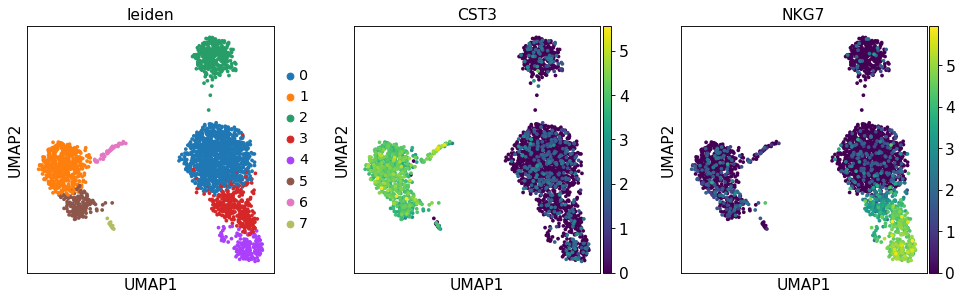

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [ ]:
# データの保存
adata.write(results_file)

## Finding marker genes

各クラスター内の発現変動遺伝子のランキングを計算します。デフォルトでは`AnnData`の.raw属性が使用されます。
発現変動解析のための最も単純で最速の方法はt-検定です。

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


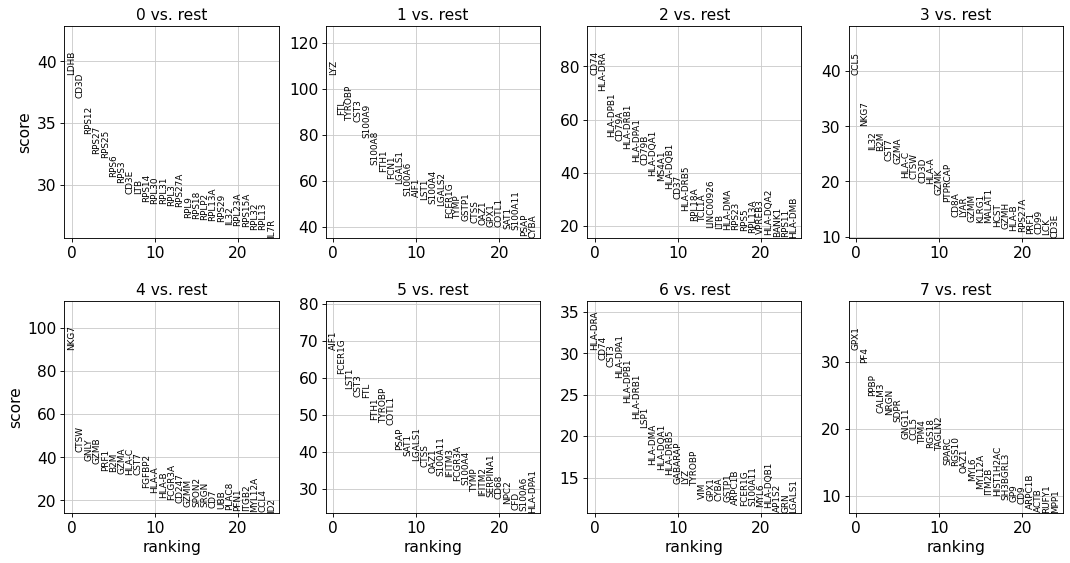

In [ ]:
# t-test
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

- Wilcoxon rank-sum (Mann-Whitney-U) test はt検定と非常に似た結果を返しますが、我々はWilcoxon testを推奨します (see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612)). 
- 更に強力な他の手法もあります（例： MAST, limma, DESeq2 and, for python, the recent diffxpy）

ranking genes
    finished (0:00:02)


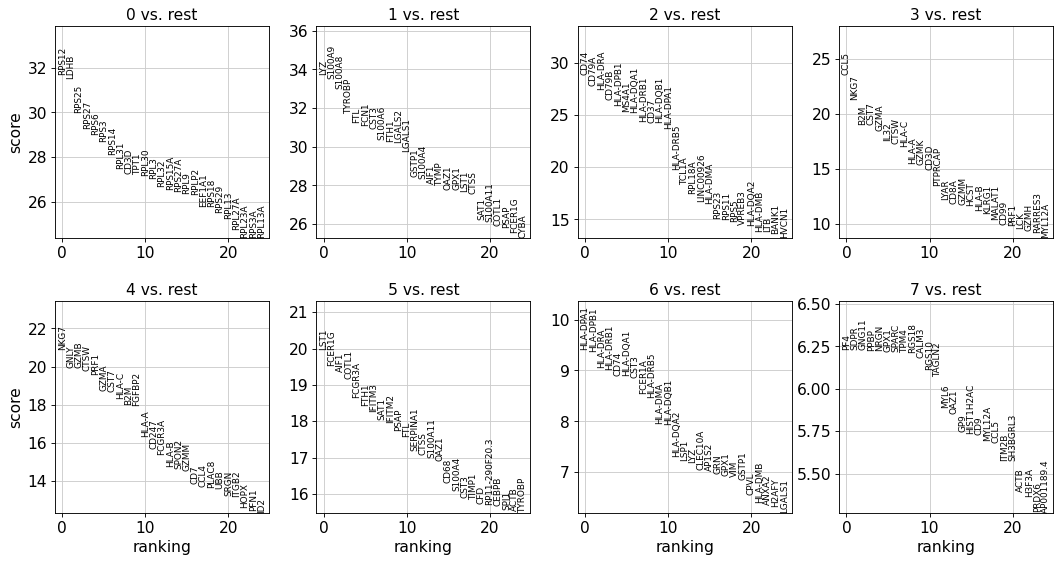

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

- 他の手法として、ロジスティック回帰を用いて遺伝子をランク付けしてみましょう ([Natranos et al. (2018)](https://doi.org/10.1101/258566))。本質的な違いは、従来の微分検定が一変量であるのに対し、ここでは多変量のアプローチを使用していることです([Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79))。

ranking genes
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:00:13)


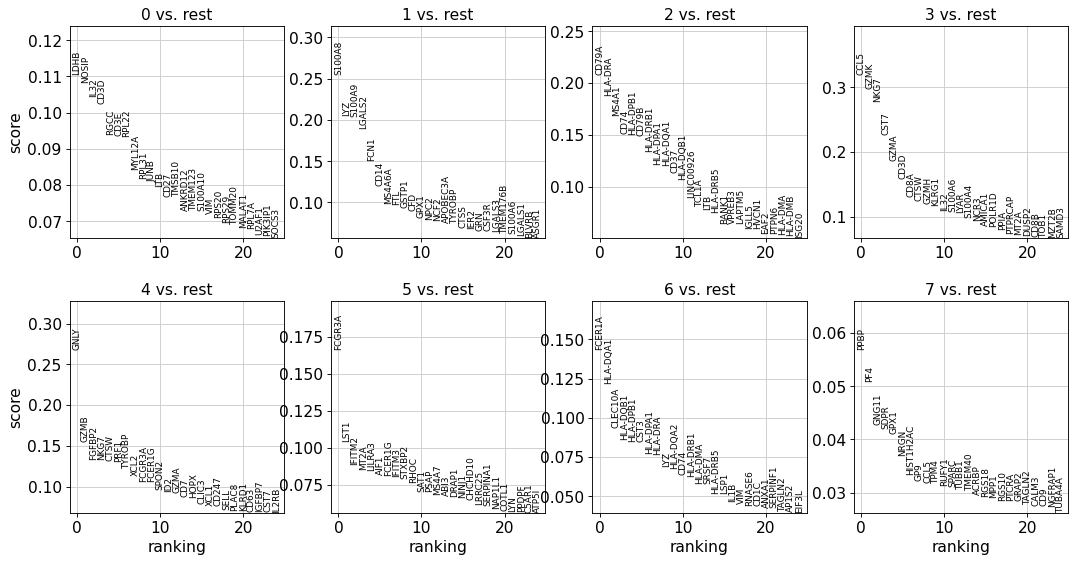

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

２つの例外を除いて、どの手法でも同様のマーカーを特定できました。

In [ ]:
# 得られたマーカー遺伝子をリスト化
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
# Wilcoxonを用いてやりなおし
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

ranking genes
    finished (0:00:03)


,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,NKG7,LST1,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,GNLY,FCER1G,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,GZMB,AIF1,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,CTSW,COTL1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,PRF1,FCGR3A,CD74,NRGN


In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.685107e-220,LYZ,7.634876e-249,CD74,3.043536e-182,CCL5,4.293729e-122,NKG7,1.203971e-96,LST1,1.322111e-88,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,3.803722e-218,S100A9,4.626358e-246,CD79A,6.860832e-170,NKG7,4.067448e-100,GNLY,1.257170e-88,FCER1G,6.259712e-85,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.835304e-197,S100A8,1.622835e-238,HLA-DRA,8.389292e-166,B2M,2.717535e-80,GZMB,1.429027e-88,AIF1,1.348814e-83,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,4.891486e-188,TYROBP,2.957652e-220,CD79B,1.171444e-153,CST7,4.485171e-80,CTSW,4.144726e-87,COTL1,5.974694e-82,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,6.839257e-185,FTL,2.479195e-214,HLA-DPB1,6.167786e-148,GZMA,7.019048e-76,PRF1,1.692100e-85,FCGR3A,1.392377e-77,CD74,5.853161e-19,NRGN,4.800511e-10


### クラスター０と１を比較

ranking genes
    finished (0:00:01)


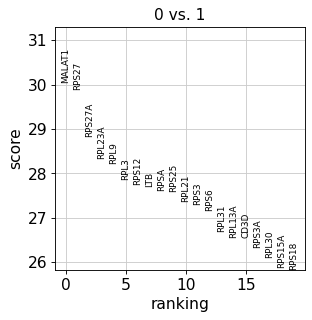

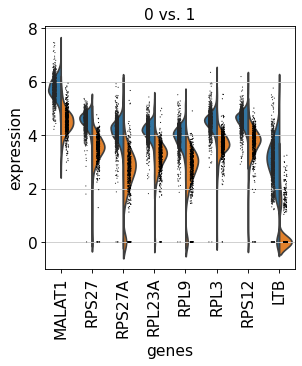

In [ ]:
# DEGランキング
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

#発現量のviolin plot
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

### 1対他クラスターの比較

ranking genes
    finished (0:00:02)


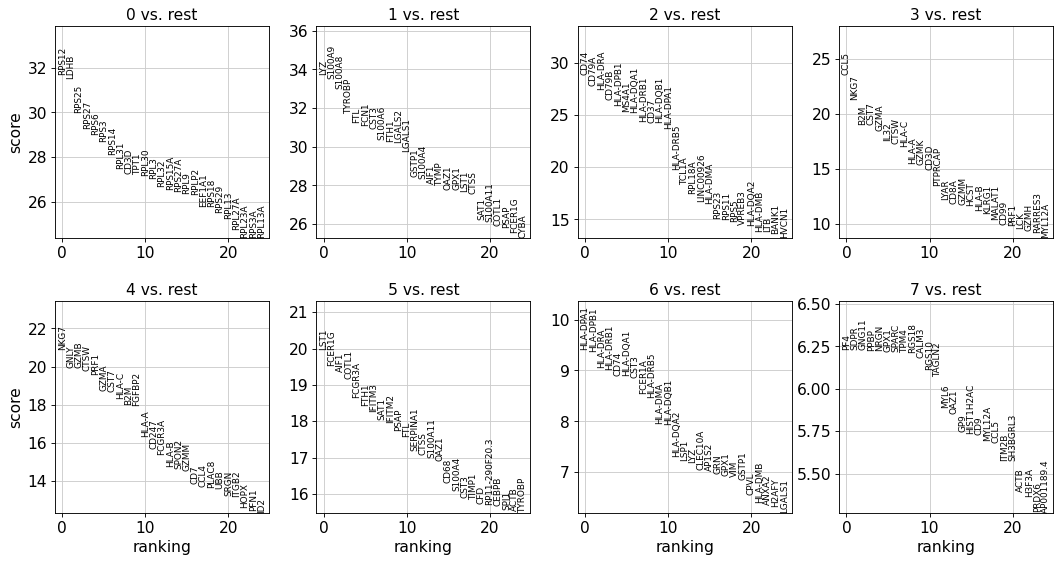

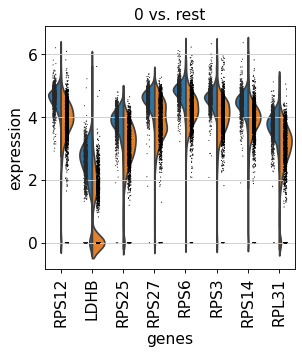

In [ ]:
adata = sc.read(results_file)
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

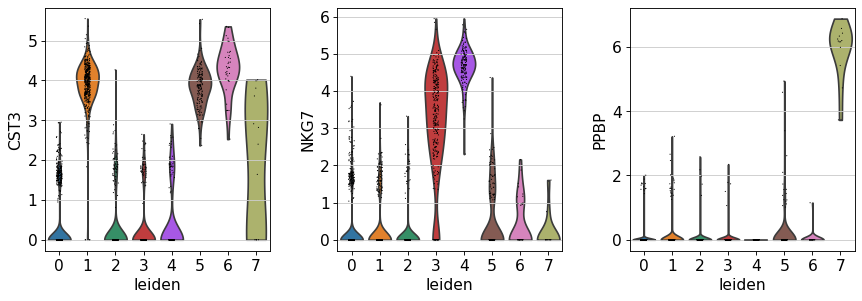

In [ ]:
# 指定した遺伝子のクラスター間発現量比較
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

### クラスターにラベルを付与

In [ ]:
new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

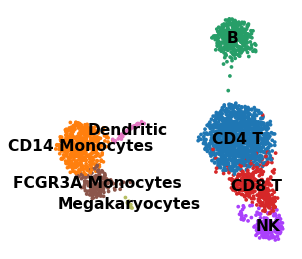

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

`marker_genes` を使ってマーカー遺伝子の発現量ヒートマップ

（作成者注：上のviolin plotでは分布がわかるが数遺伝子しか可視化できないのに対し、下のヒートマップでは平均値のみの表示だが多数の遺伝子を同時表示可能。）

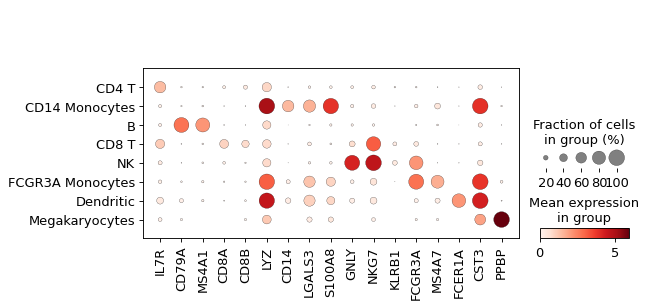

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

violin plotにすることも可能

（作成者注：busyなのであまりおすすめしない）

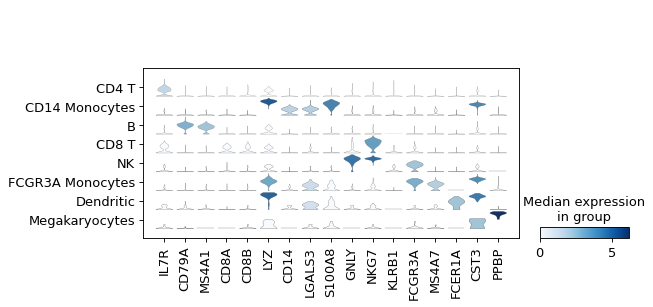

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

`compression='gzip'` で圧縮形式でオブジェクト保存

In [ ]:
adata.write(results_file, compression='gzip')

- 保存した`.h5ad`ファイルは、[h5lsコマンド](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md) を使ってファイルの大まかな概要を知ることができます 
- このファイルフォーマットは将来的にさらに最適化される可能性がありますが、すべての読み込み機能は後方互換性があります。

In [ ]:
!h5ls ./write/pmbc3k.h5ad

- このオブジェクトを単に可視化のために使いたい人と共有したい場合、ファイルサイズを小さくする簡単な方法は、スケーリング/補正された発現行列を削除することです。
- 下記コマンドで`adata.raw`に保存された raw dataを保存することができます。

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

csv形式で保存したい場合は以下のようにします：

In [ ]:
# Export single fields of the annotation of observations
adata.obs[['n_counts', 'louvain_groups']].to_csv('./write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv('./write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata.write_csvs(results_file[:-5], )

In [ ]:
from sinfo import sinfo
sinfo()

-----
anndata     0.7.6
numpy       1.19.5
pandas      1.1.5
scanpy      1.7.2
sinfo       0.3.1
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.7.1
notebook            5.3.1
-----
Python 3.7.10 (default, Feb 20 2021, 21:17:23) [GCC 7.5.0]
Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2 logical CPU cores, x86_64
-----
Session information updated at 2021-04-28 07:05
